# Chapter 07 - Beta Binomial Regression
### Setup Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from numpy.random import beta, binomial

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

%matplotlib inline

# read into dataframes
Batting = pd.read_csv('data/Batting.csv', index_col=['playerID', 'yearID'])
Pitching = pd.read_csv('data/Pitching.csv', index_col=['playerID', 'yearID'])
Master = pd.read_csv('data/Master.csv', index_col='playerID')

career = (Batting
          .query("AB > 0")
          .join(Pitching, how='left', rsuffix='_')
          .query("teamID_ != teamID_")  # IS NULL hack for `query` method -> only Batters
          .groupby(level=0)  # group by index -> playerID
          .agg({'H': np.sum, 'AB': np.sum})
          .assign(average = lambda x: x['H'] / x['AB'])
         )

career = (career
          .join(Master)
          .assign(name = lambda x: x['nameFirst'] + ' ' + x['nameLast'])
          [['name', 'H', 'AB', 'average']]  # select only columns we want
         )

# priors estimated in chapter 3
alpha0 = 75.88
beta0 = 216.69

eb_estimate_func = lambda x: (x['H'] + alpha0) / (x['AB'] + alpha0 + beta0)

career_eb = career.assign(eb_estimate=eb_estimate_func)

career_eb = career_eb.assign(alpha1 = lambda x: alpha0 + x['H'],
                             beta1 = lambda x: beta0 + x['AB'] - x['H'])
career_eb.head()

,name,H,AB,average,eb_estimate,alpha1,beta1
playerID,,,,,,,
aaronha01,Hank Aaron,3771,12364,0.304998,0.303943,3846.88,8809.69
aaronto01,Tommie Aaron,216,944,0.228814,0.236040,291.88,944.69
abadan01,Andy Abad,2,21,0.095238,0.248366,77.88,235.69
abadijo01,John Abadie,11,49,0.224490,0.254355,86.88,254.69
abbated01,Ed Abbaticchio,772,3044,0.253614,0.254117,847.88,2488.69


### Figure 7.1

Matplotlib doesn't have an easy way to get a trendline, so we'll have to do it on our own. Yes, I know this is easier with Seaborn.

In [2]:
def calculate_trend(x, y):
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
#     print("y = {:.6f}x + ({:.6f})".format(z[0],z[1]))
    return p(x)

Since the x-axis is on a log scale, we'll need to fit our linear trendline to `log(AB)`.

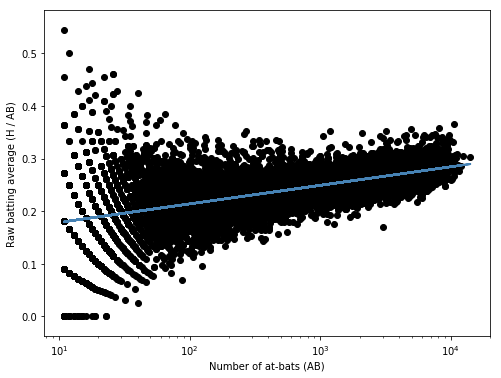

In [3]:
x = career_eb.query("AB > 10")['AB'].values
y = career_eb.query("AB > 10")['average'].values

plt.figure(figsize=(8,6))
plt.scatter(x, y, color='k')
plt.plot(x, calculate_trend(np.log(x), y), color='steelblue', linewidth=2)

plt.xscale('log')
plt.xlabel('Number of at-bats (AB)')
plt.ylabel('Raw batting average (H / AB)');

### Figure 7.2

There might be a more elegant way of doing this, but the code below is pretty straight-forward for anyone familiar with matplotlib.

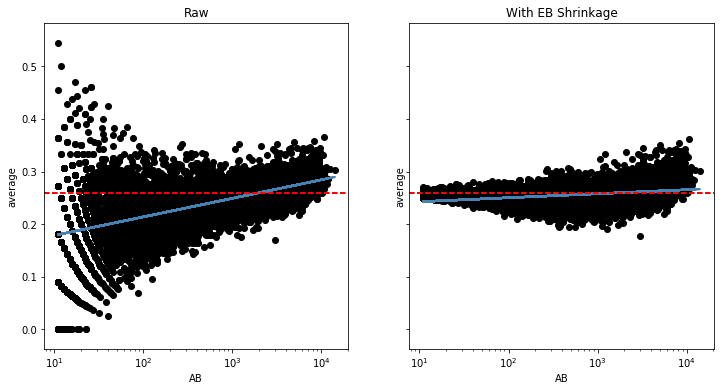

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(12, 6))

axes[0].scatter(x, y, color='k')
axes[1].scatter(x, career_eb.query("AB > 10")['eb_estimate'], color='k')

axes[0].plot(x, calculate_trend(np.log(x), y), color='steelblue', linewidth=2)
axes[1].plot(x, calculate_trend(np.log(x), career_eb.query("AB > 10")['eb_estimate']),
             color='steelblue', linewidth=2)

prior = alpha0 / (alpha0 + beta0)
axes[0].axhline(prior, color='r', linestyle='--', linewidth=2)
axes[1].axhline(prior, color='r', linestyle='--', linewidth=2)

axes[0].set_title('Raw')
axes[1].set_title('With EB Shrinkage')

axes[0].set_xlabel('AB')
axes[1].set_xlabel('AB')

axes[0].set_ylabel('average')
axes[1].set_ylabel('average')

axes[0].set_xscale('log')
axes[1].set_xscale('log')

## Section 7.3 - Step 1: Fit the model across all players

In [8]:
import pymc3 as pm
from pymc3 import Model, Beta, Binomial, Normal, traceplot, find_MAP
from pymc3 import glm

In [9]:
career_eb.head()

,name,H,AB,average,eb_estimate,alpha1,beta1
playerID,,,,,,,
aaronha01,Hank Aaron,3771,12364,0.304998,0.303943,3846.88,8809.69
aaronto01,Tommie Aaron,216,944,0.228814,0.236040,291.88,944.69
abadan01,Andy Abad,2,21,0.095238,0.248366,77.88,235.69
abadijo01,John Abadie,11,49,0.224490,0.254355,86.88,254.69
abbated01,Ed Abbaticchio,772,3044,0.253614,0.254117,847.88,2488.69


### MCMC

In [ ]:
with Model() as model:
    alpha = ''
    beta = ''
    
    true_average = Beta('true_average', alpha=alpha, beta=beta)
    hits = Binomial('hits', n='AB', p=true_average)
    
    map_estimate = find_MAP(model)
    
    print(map_estimate)

### GLM

In [ ]:
with Model() as glm_model: